# Alignment Plot 



A) do two alignments, one for the 5' homology and the other for the rest of the read

B) only overlay supplementary alignment for sequences that have been softclipped in the primary reads.

In [17]:
import matplotlib.pyplot as plt
from Bio import SeqIO
from collections import defaultdict, OrderedDict
import pysam
import re

## Parse Genbank File 

In [18]:
# make a list of IDs with specific categories 
genbank_file = '00-Data/feature_annotated/Repeatmasker_transgene_classified.gb'

# Parse the GenBank file
record_list = list(SeqIO.parse(genbank_file, 'genbank'))

allowed_category_list = ["COMPLETE", "FivePrimeTruncations", "28S_DEL_5END", "Jumps"]
read_category_dict = {}
record_dict = {}

for record in record_list:
    record_category, record_id = record.id.split("-", 1)
    if record_category in allowed_category_list:
        read_category_dict[record_id] = record_category
        record_dict[record_id] = record

len(read_category_dict)

815

## Parse SamFile 

### Fetch Reference 

In [19]:
### Fetch Reference Segments 
ref_fasta_path = "00-Data/references/ref_28s_features.fasta"

feature_range_dict = OrderedDict()

long_ref_offset = 4522 #0  # Offset for using the long reference 4522
running_total = 0 + long_ref_offset
for record in SeqIO.parse(ref_fasta_path, "fasta"):
    record_length = len(record.seq)
    feature_range_dict[record.id] = {
        "start": running_total,
        "end": running_total + record_length,
        "length" : record_length
    }
    running_total += record_length

reference_length = running_total
print("Total length of reference:", reference_length)

feature_range_dict

Total length of reference: 6824


OrderedDict([('5end_400nt', {'start': 4522, 'end': 4722, 'length': 200}),
             ('5end_200nt', {'start': 4722, 'end': 4922, 'length': 200}),
             ('Transgene', {'start': 4922, 'end': 6324, 'length': 1402}),
             ('3UTR', {'start': 6324, 'end': 6424, 'length': 100}),
             ('3end_200nt', {'start': 6424, 'end': 6624, 'length': 200}),
             ('3end_400nt', {'start': 6624, 'end': 6824, 'length': 200})])

In [20]:
# Compute combined length
insert_ref_length = {}

if "Transgene" in feature_range_dict and "3UTR" in feature_range_dict:
    insert_ref_length = {
        "start": feature_range_dict["Transgene"]["start"],
        "end": feature_range_dict["3UTR"]["end"],
        "length": feature_range_dict["3UTR"]["end"] - feature_range_dict["Transgene"]["start"]
    }
else:
    print("Warning: Missing feature lengths for Transgene and/or 3UTR.")

### Sort Samfile 

In [21]:

sam_file = "00-Data/filtered_aligned/crRNA.sam"
# Parse the SAM file with BioPython

category_alignment_dict = defaultdict(list)

with pysam.AlignmentFile(sam_file, "r") as samfile:
    for read in samfile.fetch():
        # --- Fetch Read ID and category
        read_id = read.query_name
        read_category = read_category_dict.get(read_id, "UNKNOWN")

        if read_category == "UNKNOWN" or read.is_secondary:
            # print("UNKOWN")
            continue

        category_alignment_dict[read_category].append(read)

category_alignment_dict.keys()

dict_keys(['FivePrimeTruncations', 'Jumps'])

### create List 

In [22]:
complete_read_list = category_alignment_dict["COMPLETE"]
FivePrimeTruncation_read_list = category_alignment_dict["FivePrimeTruncations"]
Jumps_read_list = category_alignment_dict["Jumps"]
five_end_del_read_list = category_alignment_dict["28S_DEL_5END"]

## Process the reads 
Repeat per read
1. Get segments (aligned, unaligned)
    1. Per segment we need start, end
2. Trim the segments (if required) to the ROI
3. Sort the list

### Helper functions 

In [23]:
class Read:
    read_id: str
    _tmp_block_dict: defaultdict


    def __init__(self, read_id, category):
        self.read_id = read_id
        self.category = category
        self._tmp_block_dict = defaultdict(list)
    
    def add_block(self, block_feature, block):
        self._tmp_block_dict[block_feature].extend(block)

    def get_blocks_ordered(self):
        out_block_list = []

        for feature_type, block_list in self._tmp_block_dict.items():
            for block in block_list:
                out_block_list.append(({
                    "start": block["start"],
                    "end": block["end"],
                    "type": feature_type,
                    "supplementary": block["supplementary"]
                }))
        
        # Sort the blocks by start position
        out_block_list.sort(key=lambda x: x["start"])
    
        # Check if there are any blocks
        if not out_block_list:
            print(f"Warning: Read {self.read_id} has no blocks")

        # Trim the soft clips 
        out_block_list = self._trim_soft_clips(out_block_list)

        return out_block_list   

    def _join_overlapping_blocks(self, blocks):
        blocks.sort(key=lambda x: x["start"])
        merged_blocks = []
        for block in blocks:
            if not merged_blocks:
                merged_blocks.append(block)
            else:
                if block["start"] <= merged_blocks[-1]["end"]:
                    merged_blocks[-1] = {"start": merged_blocks[-1]["start"], "end": block["end"]}
                else:
                    merged_blocks.append(block)
        return merged_blocks
    
    def _trim_soft_clips(self, blocks):
        """Trim overlapping soft clips, they stop when the supplementary block starts."""
        for i in range(len(blocks)):
            if blocks[i]["type"] == "Soft Clip":
                if i > 0 and blocks[i]["start"] < blocks[i-1]["end"]:
                    blocks[i]["start"] = blocks[i-1]["end"]
                if i < len(blocks) - 1 and blocks[i]["end"] > blocks[i+1]["start"]:
                    blocks[i]["end"] = blocks[i+1]["start"]
        return blocks
    
    def get_sort_criteria_feature_position(self, feature_type, start_end, first_last):
        """Sort criteria based on the attribute of a single block.
        You can specify:
        - the ype of feature to look at (e.g. "Transgene", "3UTR")
        - whether to look at the first or last block
        """
        # Parse the parameters
        if start_end not in ["start", "end"]:
            raise ValueError(f"Invalid value for start_end: {start_end}")
        
        if first_last not in ["first", "last"]:
            raise ValueError(f"Invalid value for first_last: {first_last}")
        
        first_last_index = 0 if first_last == "first" else -1

        feature_block_list = self._tmp_block_dict.get(feature_type, [])
        # If the list is empty, return position 0
        if not feature_block_list:
            return 0
        
        # Return the start of the last block
        feature_block_list.sort(key=lambda x: x["start"])
        last_block = feature_block_list[first_last_index]
        return last_block[start_end] # return start or end coordinate of the block
    
    def get_sort_criteria_gap(self, feature_type, start_end_size):
        """Sort criteria based on the gap between two blocks of the same feature type.
        You can specify:
        - the type of feature to look at (e.g. "Transgene", "3UTR")
        """
        # Parse the parameters
        if start_end_size not in ["start", "end", "size"]:
            raise ValueError(f"Invalid value for start_end: {start_end_size}")
        
        feature_block_list = self._tmp_block_dict.get(feature_type, [])
        # If the list is empty, return position 0
        if not feature_block_list or len(feature_block_list) < 2:
            return 0
        
        # Sort the blocks by start position
        feature_block_list.sort(key=lambda x: x["start"])
        
        # Iterate through list and find the largest gap
        largest_gap = 0
        gap_position = {}
        for i in range(len(feature_block_list) - 1):
            gap = feature_block_list[i + 1]["start"] - feature_block_list[i]["end"]
            if gap > largest_gap:
                largest_gap = gap
                gap_position = {
                    "start": feature_block_list[i]["end"],
                    "end": feature_block_list[i + 1]["start"]
            }
        if start_end_size == "size":
            print(f"Gap size: {largest_gap}")
            return largest_gap
        
        return gap_position.get(start_end_size, 0)
    
    def __repr__(self):
        return f"{self.read_id} {self.category} {self._tmp_block_dict}" 

### Convert to correct format

Iterate over the alignment segments, calculate the aligned blocks, mismatches etc, and add them to a new Read object.

In [24]:
def calculate_block_list(read, cigar_mapper_and_filter):
    #  --- Create blocks from get_alignment_blocks
    block_list = []

    current_block = {"cigar_type": None, "start_ref": None, "end_ref": None, "block_length": 0}
    last_pos_ref_not_none = None

    for pos_read, pos_ref, pos_cigar in read.get_aligned_pairs(with_cigar=True):
        # Map the CIGAR operation to a string and skip the ones not defined in the mapper
        if (cigar_type:=cigar_mapper_and_filter.get(pos_cigar)) is None:
            continue

        # - Create a empty new block (and save the old one)
        if cigar_type != current_block["cigar_type"]:
            # close previous block if it exists
            if current_block["cigar_type"] is not None:
                block_list.append(current_block)
            # start a new block
            current_block = {
                "cigar_type": cigar_type, 
                "start_ref": pos_ref if pos_ref is not None else -1, 
                "end_ref": pos_ref + 1 if pos_ref is not None else -1,
                "block_length": 0
            }
        # - Extend current block
        # Update the end position of the block (if it maps to the reference, otherwise it keeps the last position of -1)
        if pos_ref is not None:
            current_block["end_ref"] = pos_ref + 1
            
        
        # Add the ref position to the block
        current_block["block_length"] += 1


    # Close the last block
    if current_block["cigar_type"] is not None:
        block_list.append(current_block)
    
    # # - Post-process the clipping blocks
    for i, block in enumerate(block_list):
        if block["cigar_type"] in ("Soft Clip", "Hard Clip"):
            # If start_ref is -1, try using the next block
            if block["start_ref"] == -1 and i < len(block_list) - 1:
                next_block = block_list[i + 1]
                if next_block["start_ref"] != -1:
                    block["start_ref"] = next_block["start_ref"] - block["block_length"]
                    block["end_ref"] = next_block["start_ref"]
            
            # If end_ref is -1, try using the previous block
            if block["end_ref"] == -1 and i > 0:
                prev_block = block_list[i - 1]
                if prev_block["end_ref"] != -1:
                    block["start_ref"] = prev_block["end_ref"]
                    block["end_ref"] = prev_block["end_ref"] + block["block_length"]
    
    # Return the generated block list
    return block_list

In [25]:
read_ref_dict = {}

# Map the CIGAR operation to a human-readable string, you can combine multiple flags into one (e.g. 4 and 5 into "Clipping")
cigar_mapper = {
    4: "Soft Clip",
    5: "Hard Clip",
    7: "Sequence Match",
    8: "Sequence Mismatch",
}

# Create a copy, and add the other regions that interest us but are not returned/saved/outputted
cigar_mapper_and_filter = {
    1: "Insertion",
    2: "Deletion",
    3: "Skipped Region",
    **cigar_mapper
}

for category, read_list in category_alignment_dict.items():

    for read in read_list:
        # --- Fetch the Read object or create a new one
        read_id = read.query_name
        read_supplementary = read.is_supplementary
        # Get or create a new read object
        current_read = read_ref_dict.get(read_id, Read(read_id, category))
        # -- Get alignment blocks using the get_aligned_pairs method --
        # This method allows us to visualise for mismatches and clips
        block_list = calculate_block_list(read, cigar_mapper_and_filter=cigar_mapper_and_filter)

        # --- Add the blocks to the Read object
        # Convert the blocks to the format expected by the Read object
        for block in block_list:
            block_type = block["cigar_type"]
            start_ref = block["start_ref"]
            end_ref = block["end_ref"]

            if block_type in cigar_mapper.values():
                if block_type != "Sequence Match":
                    current_read.add_block(block_type, [{"start": start_ref, "end": end_ref, "supplementary": read_supplementary}])
                else:
                    for feature_name, feature_record in feature_range_dict.items():
                        overlap_start = max(start_ref, feature_record["start"])
                        overlap_end = min(end_ref, feature_record["end"])
                        if overlap_start < overlap_end:
                            current_read.add_block(feature_name, [{"start": overlap_start, "end": overlap_end, "supplementary": read_supplementary}])
        
        # Save the read object
        read_ref_dict[read_id] = current_read

In [26]:
# Put the reads into seperate lists
categorised_reads_dict = defaultdict(list)

for read in read_ref_dict.values():
    categorised_reads_dict[read.category].append(read)

complete_read_list = categorised_reads_dict["COMPLETE"]
FivePrimeTruncation_read_list = categorised_reads_dict["FivePrimeTruncations"]
Jumps_read_list = categorised_reads_dict["Jumps"]
five_end_del_read_list = categorised_reads_dict["28S_DEL_5END"]

### Reclassification

FivePrimeTruncation -> Complete

In [27]:
# Define the maximum length of deletions and skipped regions to be considered as "long".
# If the length is shorter than this threshold, it will be reclassified from FivePrimeTruncations to Complete
long_D_or_N_threshold = 4

tmp_FivePrimeTruncations_list = []
recategorised_reads_dict_1 = categorised_reads_dict.copy()

reclassified_complete_counter = 0
for read in recategorised_reads_dict_1["FivePrimeTruncations"]:
    has_long_D_or_N = False

    # --- Calculate the gaps between the blocks within the Insert region
    block_list = read.get_blocks_ordered()
    lower = insert_ref_length["start"]
    upper = insert_ref_length["end"]

    gap_list = []
    prev_end = lower

    for block in block_list:
        # Clip to boundaries
        start = max(block["start"], lower)
        end = min(block["end"], upper)
        # If it's outside the boundaries, ignore
        if start < end:
            # Check if there's a gap between this and the previous block
            if start > prev_end:
                gap_list.append(start - prev_end)
            prev_end = max(prev_end, end)

    if prev_end < upper:
        gap_list.append(upper - prev_end)
    
    # --- Reclassify the read if it has a long deletion or skipped region
    if not any(gap >= long_D_or_N_threshold for gap in gap_list):
        read.category = "COMPLETE"
        recategorised_reads_dict_1["COMPLETE"].append(read)
        reclassified_complete_counter += 1
    else:
        tmp_FivePrimeTruncations_list.append(read)

recategorised_reads_dict_1["FivePrimeTruncations"] = tmp_FivePrimeTruncations_list

print(f"Reclassified {reclassified_complete_counter} reads from FivePrimeTruncations to Complete.")

Reclassified 452 reads from FivePrimeTruncations to Complete.


FivePrimeTruncation -> Jumps

In [28]:
reclassified_Jumps_counter = 0


tmp_FivePrimeTruncations_list = []
recategorised_reads_dict_2 = recategorised_reads_dict_1.copy()


for read in recategorised_reads_dict_2["FivePrimeTruncations"]:
   has_alignment_in_junction = False
   has_UTR = False

   for block in read.get_blocks_ordered():
       if block["type"] == "3UTR":
            has_UTR = True

       
       if block["type"] == "Transgene":
           if (block["start"] < 410 + long_ref_offset):
               has_alignment_in_junction = True
               break
  
   if has_alignment_in_junction or (not has_UTR):
       read.category = "Jumps"
       recategorised_reads_dict_2["Jumps"].append(read)
       reclassified_Jumps_counter += 1
   else:
       tmp_FivePrimeTruncations_list.append(read)

recategorised_reads_dict_2["FivePrimeTruncations"] = tmp_FivePrimeTruncations_list

print("Reclassified reads FivePrimeTruncations > Jumps:", reclassified_Jumps_counter)

Reclassified reads FivePrimeTruncations > Jumps: 91


In [29]:
recategorised_reads_dict_3 = recategorised_reads_dict_2.copy()
# Initialize the "Other" category in recategorised_reads_dict_2 if it doesn't exist
if "Other" not in recategorised_reads_dict_2:
    recategorised_reads_dict_2["Other"] = []

In [30]:
# Define the reference range for insertions and the minimum consecutive insertion threshold
insertion_ref_start = 4922
insertion_ref_end = 6024
min_consecutive_insertions = 4

# Initialize counters and a list to hold reads that remain in "COMPLETE"
reclassified_other_counter = 0
remaining_complete_reads = []

# Iterate over all reads in the "COMPLETE" category
for read in recategorised_reads_dict_3["COMPLETE"]:
    has_consecutive_insertions = False
    block_list = read.get_blocks_ordered()
    
    # Iterate through each block to find insertions within the specified range
    for block in block_list:
        if block["type"] == "Insertion":
            # Check if the insertion starts within the reference range
            if insertion_ref_start <= block["start"] < insertion_ref_end:
                # Calculate the length of the insertion
                insertion_length = block["end"] - block["start"]
                
                # Check if the insertion length meets or exceeds the threshold
                if insertion_length >= min_consecutive_insertions:
                    has_consecutive_insertions = True
                    break  # No need to check further blocks for this read
    
    # Reclassify the read based on the presence of consecutive insertions
    if has_consecutive_insertions:
        read.category = "Other"
        recategorised_reads_dict_2["Other"].append(read)
        reclassified_other_counter += 1
    else:
        remaining_complete_reads.append(read)

# Update the "COMPLETE" category with reads that were not reclassified
recategorised_reads_dict_3["COMPLETE"] = remaining_complete_reads

# Output the number of reads reclassified
print(f"Reclassified {reclassified_other_counter} reads from Complete to Other based on insertions.")

Reclassified 0 reads from Complete to Other based on insertions.


In [31]:
complete_read_list = recategorised_reads_dict_2["COMPLETE"]
FivePrimeTruncations_read_list = recategorised_reads_dict_2["FivePrimeTruncations"]
Jumps_del_read_list = recategorised_reads_dict_2["Jumps"]
five_end_del_read_list = recategorised_reads_dict_2["28S_DEL_5END"]

# Sort the reads based on the transgene length
# complete_read_list.sort(key=lambda x: x.get_sort_criteria_feature_position(feature_type="Transgene", start_end="start", first_last="last"))
# FivePrimeTruncations_read_list.sort(key=lambda x: x.get_sort_criteria_feature_position(feature_type="Transgene", start_end="start", first_last="last"))
# Jumps_read_list.sort(key=lambda x: x.get_sort_criteria_feature_position(feature_type="Transgene", start_end="start", first_last="last")) 
# five_end_del_read_list.sort(key=lambda x: x.get_sort_criteria_feature_position(feature_type="3end_200nt", start_end="start", first_last="first"))
# complete_read_list.sort(key=lambda x: x.get_sort_criteria_gap(feature_type="Transgene", start_end_size="end"))
FivePrimeTruncations_read_list.sort(key=lambda x: x.get_sort_criteria_feature_position(feature_type="Transgene", start_end="start", first_last="first"))  
FivePrimeTruncations_read_list.sort(key=lambda x: x.get_sort_criteria_feature_position(feature_type="3UTR", start_end="start", first_last="first"))  
Jumps_read_list.sort(key=lambda x: x.get_sort_criteria_gap(feature_type="Transgene", start_end_size="end"))
five_end_del_read_list.sort(key=lambda x: x.get_sort_criteria_gap(feature_type="3end_200nt", start_end_size="end"))


## Plot the Reads and Segments 

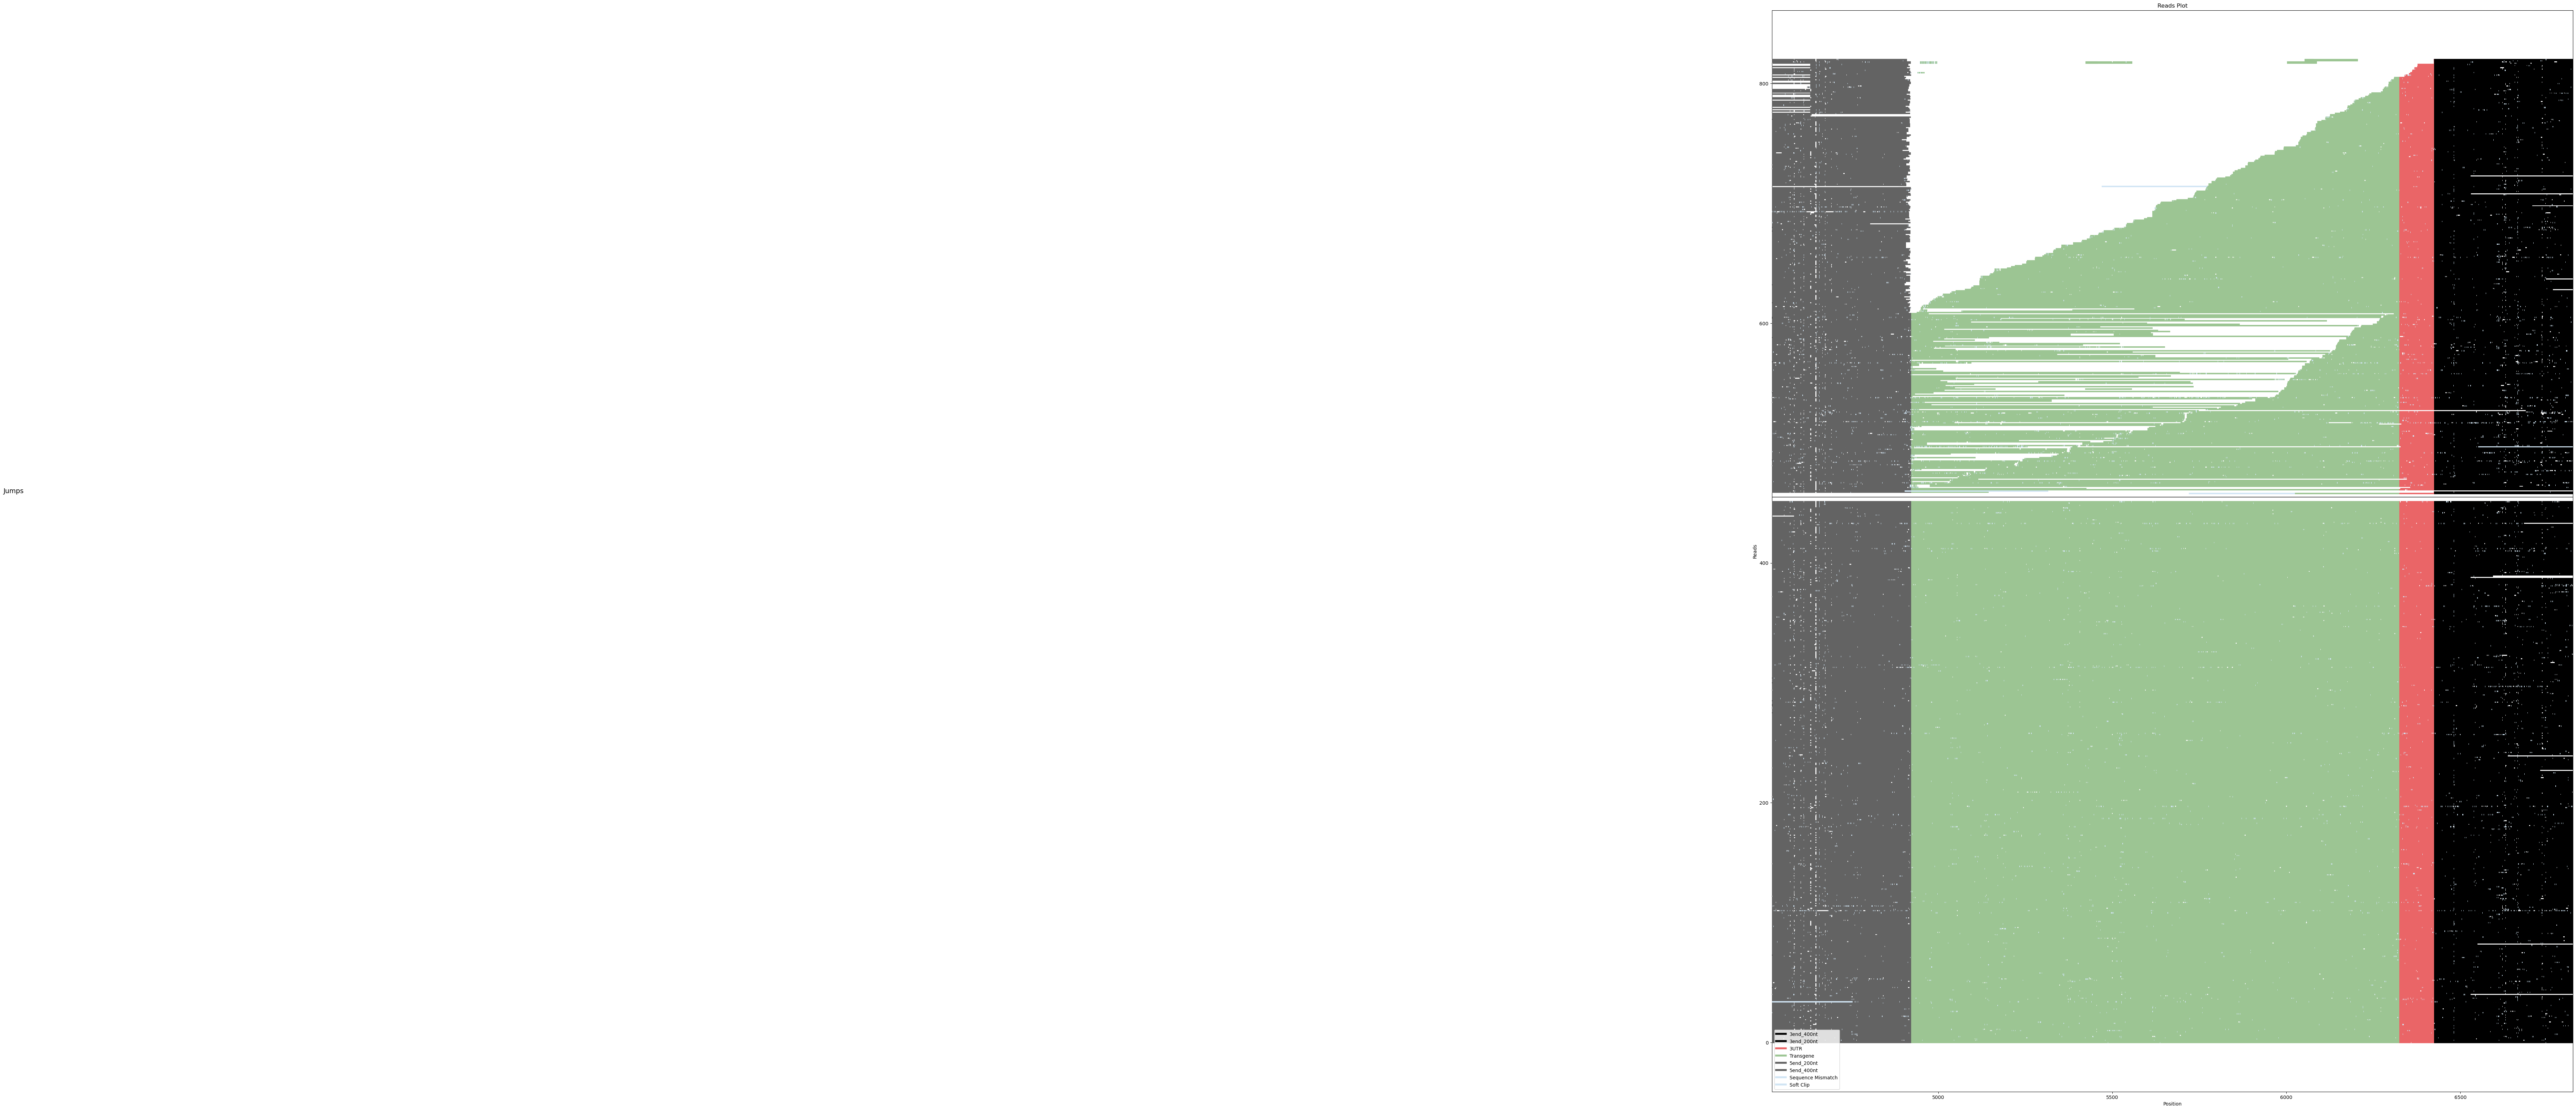

In [32]:
# --- Define Reads to Plot and Colours ---
total_read_list = (
    complete_read_list +
    five_end_del_read_list +
    Jumps_read_list +
    FivePrimeTruncations_read_list +
    []
)

# filtered_read_list = []
# discarded_read_ids = ["fd4d59ab-f474-4841-8ee9-9b0f6d7c62ea"]
# for read in total_read_list: 
    # if read.read_id not in discarded_read_ids:
    #     filtered_read_list.append (read)

category_colors = {
    "3end_400nt": "#000000",
    "3end_200nt": "#000000",
    "3UTR": "#EA6567",
    "Transgene": "#9CC593",
    "5end_200nt": "#636363",
    "5end_400nt": "#636363",
    "Sequence Mismatch": "#D1E5F4",
    "Soft Clip": "#D1E5F4",#D3D3D3
}

# --- Start plotting
plt.figure(figsize=(30, len(read_ref_dict)*0.05))

# -- Plot all the reads
TEXT_X_OFFSET = -500  # Offset for the text labels
H_LINE_SPACE = 3  # Space between the dividing lines
READ_LINE_WIDTH = 3  # Width of the read blocks
READ_GAP_WIDTH = 0  # Space between the read lines
SUPPLEMENTARY_LINE_STYLE = "-"  # Line style for supplementary reads "--" for dashed or "_" for solid

current_category = None
prev_category = None 

running_y_offset = 0 
for i, read_data in enumerate(total_read_list):
    # Draw a line between categories
    if current_category != read_data.category:
        prev_category = current_category
        current_category = read_data.category
        
        # Draw divider line only when transitioning from COMPLETE
        if prev_category == "COMPLETE":
            plt.axhline(i + running_y_offset + H_LINE_SPACE, color="black", lw=1)
            # Show category text label
            plt.text(TEXT_X_OFFSET, i + running_y_offset + H_LINE_SPACE + 5, current_category, ha="right", va="center", fontsize=14)
            running_y_offset += 2 * H_LINE_SPACE
    
    # Plot the read blocks
    block_list = read_data.get_blocks_ordered() 
    for block in block_list:
        # -- Change if you want to exclude certain block types (Clips, supplementary, non supplementary, etc)
        # if block["type"] == "Soft Clip":
        #     continue
        # if block["supplementary"]:
        #     continue

        plt.hlines(y=i + running_y_offset,
               xmin=block["start"],
               xmax=block["end"],
               colors=category_colors.get(block["type"], "red"),    # segment color
               linewidth=READ_LINE_WIDTH,
               linestyle=SUPPLEMENTARY_LINE_STYLE if block["supplementary"] else "-",
               capstyle='butt',                                     # flat ends
               zorder=6 if block["supplementary"] else 5,          # supplementary reads on top
            #    hatch="x" if block["supplementary"] else None,      # hatch for supplementary reads
               )
    # optional: print read ID nect to your reads (to manually investigate reads)
    # plt.text(TEXT_X_OFFSET, i + running_y_offset, read_data.read_id, ha="right", va="center", fontsize=10)
    # Add gap to the next read
    # running_y_offset += READ_GAP_WIDTH
# -- Add a legend for the feature types
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=color, lw=4, label=ftype) for ftype, color in category_colors.items()]
plt.legend(handles=legend_elements, loc='lower left')

# -- Set the plot labels and title and Axis limits
plt.xlim(0 + long_ref_offset, reference_length -1)  # Comment out to show the full read length
plt.xlabel("Position")
plt.ylabel("Reads")
plt.title("Reads Plot")

# --- I/O ops: Save the plot as PDF ---
plt.savefig("05-Alignment-Plot.pdf")
plt.show()